## Supercontinuum and second harmonic generations

We begin by the typical Python imports.

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
import time
import scipy
import copy
from matplotlib import cm
import colorcet as cc
from matplotlib.colors import Normalize

#This are my libraries
import nlo 
import materials
import waveguides
from util import sech

In [2]:
# Change size of plots (for wider plots)
plt.rcParams['figure.figsize'] = [10, 5]

## Units
We'll work mainly in SI units.

In [3]:
from scipy.constants import pi, c, epsilon_0

## Time and Frequency domain windows

Now we need to determine an FFT size $N$, this will be the common size for the time and frequency axis in our simulations. We also need to select how large the time window $2 T_{\mathrm{max}}$ for our simulations will be. The time window needs to be large enough so that pulses don't reach the edge of the domain at any point. Since we'll usually pick a reference frame that moves with one of the pulses, then how much the other pulses travel depends on the respective group velocity mismatch. The sampling period $\Delta t$ will be determined by the size of the window and the number of points; Nyquist criteria must be satisfied as usual.

Once the number of points and time-window has been selected, the frequency grid is fixed by the FFT, with a frequency resolution
$$ F_s = \frac{1}{N \Delta t},$$
the minimum frequency is 0 while the maximum frequency is
$$ F_{\mathrm{max}} = \pm \frac{1}{2\Delta t}.$$
The maximum frequency should alway be below the desired absolute carrier frequency. So the longest wavelength allowed becomes:
$$ \lambda_{\mathrm{max}} = \frac{c}{F_{\mathrm{max}}} = 2c\Delta t $$

In [4]:
NFFT = 2**9 #Number of FFT points

Tmax = 1000e-15 #(fs) (window will go from -Tmax to Tmax)
t = np.linspace(-Tmax, Tmax, NFFT, endpoint=False)
dt = t[1]-t[0] #Sampling period
print('Sampling Rate = %0.3f fs' %(dt*1e15))

f = fftshift(fftfreq(NFFT, dt))
omega = 2*pi*f
Fmax = abs(np.amin(f))
print('Frequency Resolution = %0.3f THz' %((f[1]-f[0])*1e-12))
print('Maximum Fourier frequency = %0.3f THz' %(Fmax*1e-12))
print('Longest wavelength allowed = %0.3f um' %(c/Fmax*1e6))

Sampling Rate = 3.906 fs
Frequency Resolution = 0.500 THz
Maximum Fourier frequency = 128.000 THz
Longest wavelength allowed = 2.342 um


## Fundamental pulse creation

Pulse energy =  1.00e+01 pJ
Pulse energy =  1.00e+01 pJ


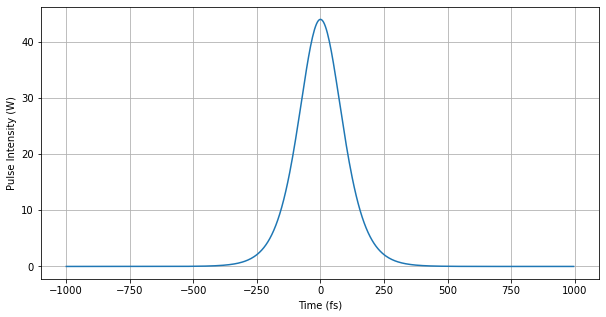

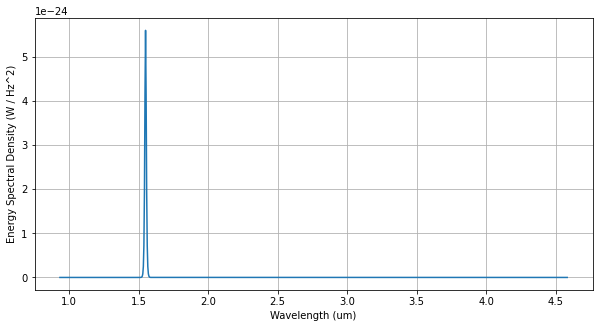

In [5]:
Tp = 200e-15 #Input pulse width
tau = Tp/1.76
rep_rate = 250e6
pump_pwr = 0.0025 #Average pump power (W)
pulse_1 = np.sqrt(0.88/rep_rate/Tp*pump_pwr)*sech(t/tau)

wl0_1= 1.55e-6 #pump wavelength
f0_1 = c/wl0_1 #Center frequency fundamental
omega0_1 = 2*pi*f0_1 #Central angular frequency for fundamental pulse

f_1 = f + f0_1 #Array of absolute frequencies
wl_1 = c/f_1 #Array of wavelengths

nlo.plot_magsq(t*1e15, pulse_1)
nlo.plot_ESD_vs_wavelength(t, pulse_1, f0_1, shift=False)
print('Pulse energy = ', format(nlo.energy_td(t, pulse_1)*1e12, '0.2e'), 'pJ')
print('Pulse energy = ', format(nlo.energy_fd(t, pulse_1)*1e12, '0.2e'), 'pJ')

## SH pulse creation

1.98e-20 pJ
1.98e-20 pJ


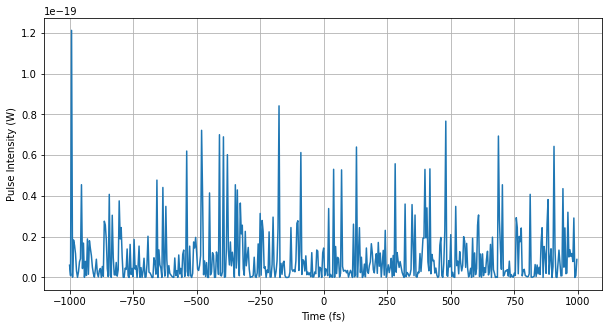

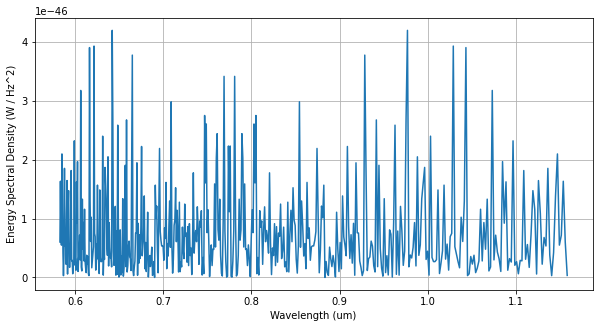

In [6]:
#Pulse creation
pulse_2 = 1e-10*np.random.normal(size=NFFT)

#Parameters
wl0_2 = wl0_1/2 #pump wavelength
f0_2 = c/wl0_2 #Center frequency fundamental
omega0_2 = 2*pi*f0_2 #Central angular frequency for fundamental pulse

f_2 = f + f0_2 #Array of absolute frequencies
wl_2 = c/f_2 #Array of wavelengths

nlo.plot_magsq(t*1e15, pulse_2)
nlo.plot_ESD_vs_wavelength(t, pulse_2, f0_2, shift=False)
print(format(nlo.energy_td(t, pulse_2)*1e12, '0.2e'), 'pJ')
print(format(nlo.energy_fd(t, pulse_2)*1e12, '0.2e'), 'pJ')

## Waveguides

In [7]:
#Waveguide geometry
etch = 0.35
dridge = 0.7
dslab = dridge - etch
wridge = 1.5

### Dispersion operator for pump (1.55um)

Central Wavelength =  1.55 um
Central Frequency = 193.414 THz


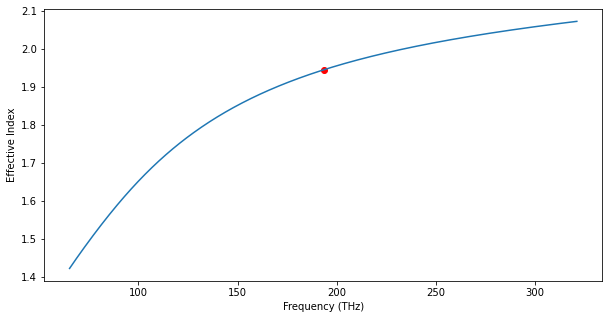

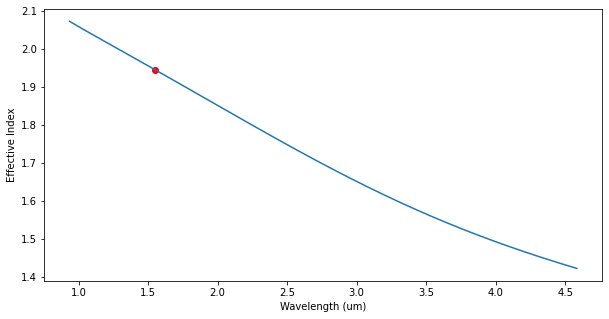

In [8]:
print("Central Wavelength = ", wl0_1*1e6, "um")
print("Central Frequency = %0.3f THz" %(f0_1*1e-12))

#Effective index
neff_1 = np.zeros(f.shape)
for kf in range(f.size):
    wl = wl_1[kf]*1e6 #Wavelength in microns
    
    #Material properties
    n0 = 1
    nLN = materials.refractive_index('LN_MgO_e', wl)
    nSiO2 = materials.refractive_index('SiO2', wl)
    #Effective index method
    n_slab = waveguides.neff_asymmetric_slab(n0, nLN, nSiO2, dslab, wl, mode='TE even', order=0)
    n_ridge = waveguides.neff_asymmetric_slab(n0, nLN, nSiO2, dridge, wl, mode='TE even', order=0)
    neff_1[kf] = waveguides.neff_symmetric_slab(n_slab, n_ridge, wridge, wl, mode='TM even', order=0)
    
    if wl_1[kf]==wl0_1:
        n0_1 = neff_1[kf] #Effective index at central frequency
        dndf_0 = (neff_1[kf] - neff_1[kf-1])/(f[kf] - f[kf-1])
        n0_index_1 = kf 
    
plt.plot(f_1*1e-12, neff_1);
plt.scatter(f0_1*1e-12, n0_1, c='r');
plt.xlabel('Frequency (THz)');
plt.ylabel('Effective Index');

fig = plt.figure()
plt.plot(wl_1*1e6, neff_1);
plt.scatter(wl0_1*1e6, n0_1, c='r');
plt.xlabel('Wavelength (um)');
plt.ylabel('Effective Index');

The dispersion operator is
$$
D = \exp(j K h),
$$
where
$$K = \beta - \beta_0 - \frac{\omega-\omega_0}{v_{ref}} = \frac{\omega n}{c} - \frac{\omega_0 n_0}{c} - \frac{\omega-\omega_0}{v_{ref}}$$,

and $v_{ref}$ is the reference group velocity, which in this case we'll choose to be the group velocity of the fundamental at the center frequency.

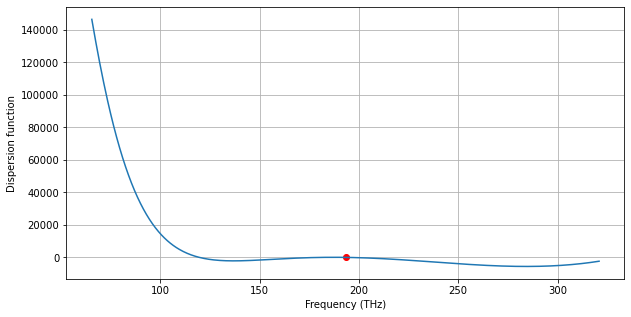

In [9]:
beta_1 = 2*pi*f_1*neff_1/c 
beta_1_0 = 2*pi*f0_1*n0_1/c 
vref = c/(n0_1 + f0_1*dndf_0)

K1 = beta_1 - beta_1_0 - 2*pi*f/vref

plt.plot(f_1*1e-12, K1)
plt.scatter(f0_1*1e-12, K1[n0_index_1], c='r');
plt.xlabel('Frequency (THz)');
plt.ylabel('Dispersion function');
plt.grid()

# D1 = np.exp(1j*K1)

### Dispersion operator for second harmonic (0.775um)

Central Wavelength =  0.775 um
Central Frequency = 386.829 THz


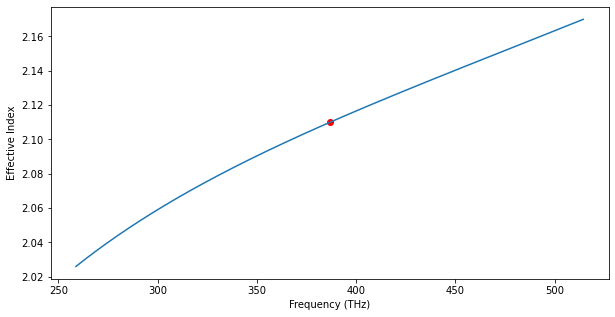

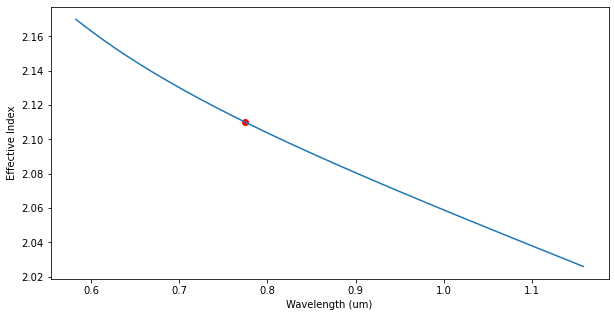

In [10]:
print("Central Wavelength = ", wl0_2*1e6, "um")
print("Central Frequency = %0.3f THz" %(f0_2*1e-12))

#Effective index
neff_2 = np.zeros(f.shape)
for kf in range(f.size):
    wl = wl_2[kf]*1e6 #Wavelength in microns
    
    #Material properties
    n0 = 1
    nLN = materials.refractive_index('LN_MgO_e', wl)
    nSiO2 = materials.refractive_index('SiO2', wl)
    #Effective index method
    n_slab = waveguides.neff_asymmetric_slab(n0, nLN, nSiO2, dslab, wl, mode='TE even', order=0)
    n_ridge = waveguides.neff_asymmetric_slab(n0, nLN, nSiO2, dridge, wl, mode='TE even', order=0)
    neff_2[kf] = waveguides.neff_symmetric_slab(n_slab, n_ridge, wridge, wl, mode='TM even', order=0)
    
    if wl_2[kf]==wl0_2:
        n0_2 = neff_2[kf] #Effective index at central frequency
        n0_index_2 = kf 
    
plt.plot(f_2*1e-12, neff_2);
plt.scatter(f0_2*1e-12, n0_2, c='r');
plt.xlabel('Frequency (THz)');
plt.ylabel('Effective Index');

fig = plt.figure()
plt.plot(wl_2*1e6, neff_2);
plt.scatter(wl0_2*1e6, n0_2, c='r');
plt.xlabel('Wavelength (um)');
plt.ylabel('Effective Index');

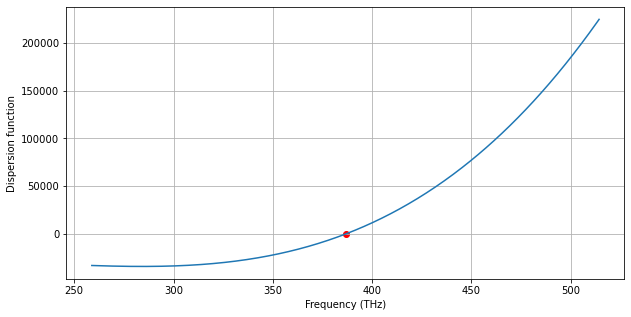

In [11]:
beta_2 = 2*pi*f_2*neff_2/c 
beta_2_0 = 2*pi*f0_2*n0_2/c 

K2 = beta_2 - beta_2_0 - 2*pi*f/vref

plt.plot(f_2*1e-12, K2)
plt.scatter(f0_2*1e-12, K2[n0_index_2], c='r');
plt.xlabel('Frequency (THz)');
plt.ylabel('Dispersion function');
plt.grid()

# D2 = np.exp(1j*K2)

## Nonlinear  Stuff

In [12]:
def nonlinear_operator(a, b, nlc):
    f = -1j*ifft(nlc*np.conj(PM)*fft(b*np.conj(a)))
    g = -1j*ifft(nlc*PM*fft(a*a))
    return np.array([f,g])

In [13]:
def propagate(x, y):
    
    x_evol = 1j*np.zeros([t.size,steps+1])
    y_evol = 1j*np.zeros([t.size,steps+1])
    
    x_evol[:,0] = x
    y_evol[:,0] = y
    
    for kz in range(steps):
        #Linear step
        x = ifft(Da*fft(x))
        y = ifft(Db*fft(y))

        #Nonlinear step
        #Runge-Kutta 4th order
        [k1, l1] = h*nonlinear_operator(x,y,nlc)
        [k2, l2] = h*nonlinear_operator(x+k1/2,y+l1/2,nlc)
        [k3, l3] = h*nonlinear_operator(x+k2/2,y+l2/2,nlc)
        [k4, l4] = h*nonlinear_operator(x+k3,y+l3,nlc)

        x = x + (1/6)*(k1+2*k2+2*k3+k4)
        y = y + (1/6)*(l1+2*l2+2*l3+l4)
        
        x_evol[:,kz+1] = x
        y_evol[:,kz+1] = y

    return x, y, x_evol, y_evol

## Nonlinear element

Similarly, we create a nonlinear element.

step size = 20.00 um
Number of steps = 300


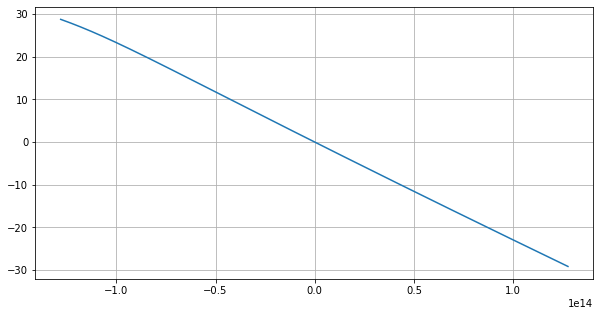

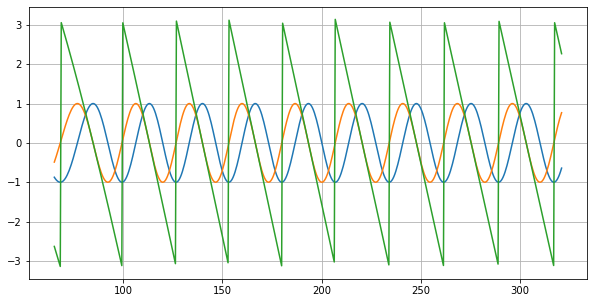

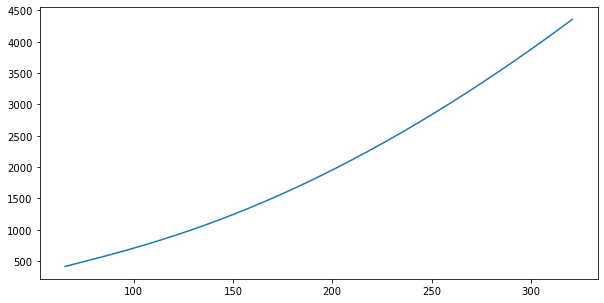

In [14]:
#Crystal parameters
L = 6e-3
h = 1e-3/50
steps = int(L/h)

print('step size = %0.2f um' %(h*1e6))
print('Number of steps = %i' %(steps))

#Dispersion operators
Da = np.exp(1j*K1*h)
Db = np.exp(1j*K2*h)
Da = fftshift(Da)
Db = fftshift(Db)

#Phase mismatch operator
PP = wl0_2/(n0_2 - n0_1)
delta_k = beta_2 - 2*beta_1 - 2*pi/PP
delta_k = delta_k/4
plt.plot(f, delta_k*h)
plt.grid()

PM = np.exp(1j*delta_k*h)
# PM = fftshift(PM)

plt.figure()
plt.plot(f_1*1e-12, np.real(PM))
plt.plot(f_1*1e-12, np.imag(PM))
plt.plot(f_1*1e-12, np.angle(PM))
plt.grid()

#Nonlinear coupling

# eta0 = 1000 # (%/W/cm^2)
# eta0 = eta0*(1e2)**2 #(%/W/m^2)
# nlc = np.sqrt(eta0)

d33 = 21e-12
deff = 2/pi*d33
Aeff = 1.5*(1e-6)**2

eta0 = 2*(deff**2)*(2*pi*f_1)**2/(neff_1**2 * neff_2 * epsilon_0*c**3 * Aeff)
plt.figure()
plt.plot(f_1*1e-12, eta0*100*1e-4)

nlc = np.sqrt(eta0)

## Single pass

In [15]:
[a, b, a_evol, b_evol] = propagate(pulse_1, pulse_2)

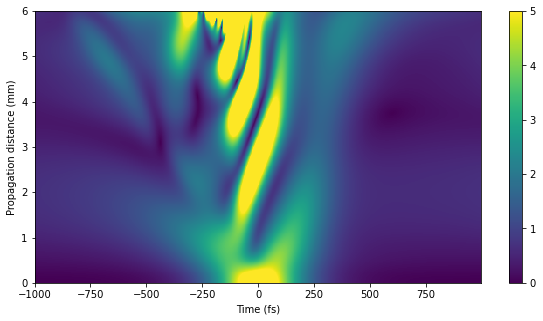

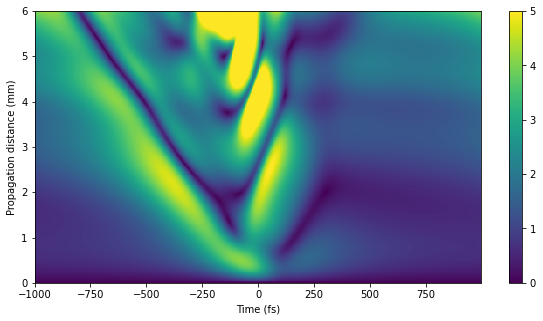

In [16]:
X,Y = np.meshgrid(t*1e15, np.arange(steps+1)*h*1e3)
plt.pcolormesh(X, Y, (np.transpose(np.abs(a_evol))), vmax=5, vmin=0)
plt.xlabel('Time (fs)')
plt.ylabel('Propagation distance (mm)')
plt.colorbar()

plt.figure()
plt.pcolormesh(X, Y, (np.transpose(np.abs(b_evol))), vmax=5, vmin=0)
plt.xlabel('Time (fs)')
plt.ylabel('Propagation distance (mm)')
plt.colorbar()

Text(0, 0.5, 'Propagation distance (mm)')

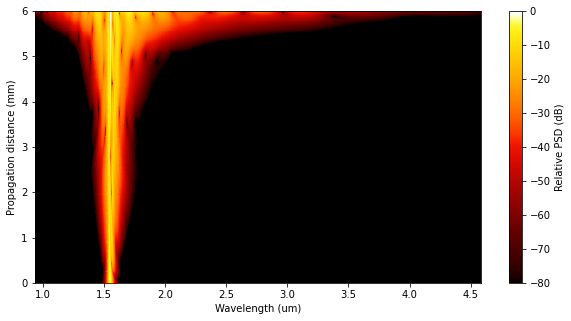

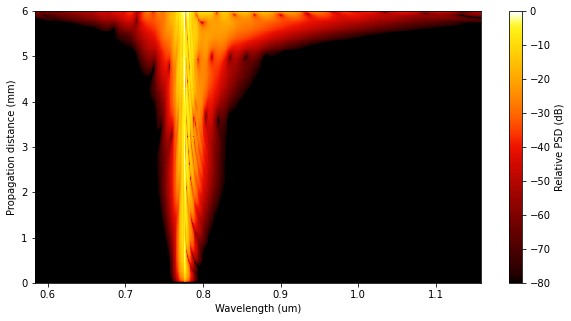

In [17]:
X1,Y1 = np.meshgrid(f_1*1e-12, np.arange(steps+1)*h*1e3)
X1wl,Y1wl = np.meshgrid(wl_1*1e6, np.arange(steps+1)*h*1e3)
X2,Y2 = np.meshgrid(f_2*1e-12, np.arange(steps+1))
X2wl,Y2wl = np.meshgrid(wl_2*1e6, np.arange(steps+1)*h*1e3)

A_evol = np.zeros((t.size, steps+1))
B_evol = np.zeros((t.size, steps+1))

for k in range(steps+1):
    x = a_evol[:,k]
    _ , Aesd = nlo.get_esd(t*1e15,x)
    A_evol[:,k] = 10*np.log10(Aesd)
    
    x = b_evol[:,k]
    _ , Besd = nlo.get_esd(t*1e15,x)
    B_evol[:,k] = 10*np.log10(Besd)

offset = np.amax(A_evol)
A_evol = A_evol - offset
B_evol = B_evol - offset
    
plt.figure()
plt.pcolormesh(X1wl, Y1wl, (np.transpose(A_evol)), cmap = cc.cm["fire"], vmin=-80, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Wavelength (um)')
plt.ylabel('Propagation distance (mm)')

plt.figure()
plt.pcolormesh(X2wl, Y2wl, (np.transpose(B_evol)), cmap = cc.cm["fire"], vmin=-80, vmax=0)
cb = plt.colorbar()
cb.set_label('Relative PSD (dB)')
plt.xlabel('Wavelength (um)')
plt.ylabel('Propagation distance (mm)')

## Merging the pulses

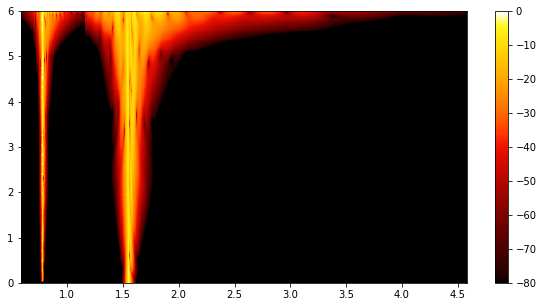

In [18]:
plt.pcolormesh(X1wl, Y1wl, (np.transpose(A_evol)), cmap = cc.cm["fire"], vmin=-80, vmax=0)
plt.pcolormesh(X2wl, Y2wl, (np.transpose(B_evol)), cmap = cc.cm["fire"], vmin=-80, vmax=0)
cb = plt.colorbar()

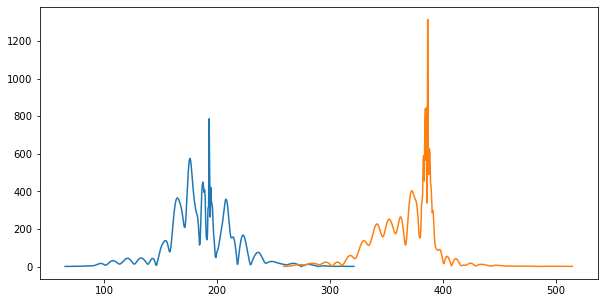

In [19]:
A = fftshift(fft(a))
B = fftshift(fft(b))

plt.plot(f_1*1e-12, abs(A))
plt.plot(f_2*1e-12, abs(B))

In [20]:
np.amax(abs(A))

786.8884137213827

In [21]:
np.amax(abs(B))

1316.2155734476084